In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms 
import tqdm
import matplotlib.pyplot as plt


In [2]:
class Swish(nn.Module):
  """x*sigmoid(x)"""
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x*torch.sigmoid(x)


In [3]:
class DWBlock(nn.Module):
  # 出力が同じサイズになるようにパディングはk//2 (ただしkは奇数)
  def __init__(self, in_c, k, s, p, bias=False):
    if p != k//2:
      print("output may not be the same spatial size as input")
    super().__init__()
    self.dw = nn.Conv2d(in_c, in_c, kernel_size=k, stride=s, padding=p, groups=in_c, bias=bias)
    self.bn = nn.BatchNorm2d(in_c)
    self.act = Swish()

  def forward(self, x):
    out = self.act(self.bn(self.dw(x)))
    return out


In [4]:
class DWBlock(nn.Module):
  # 出力が同じサイズになるようにパディングはk//2 (ただしkは奇数)
  def __init__(self, in_c, k, s, p, bias=False):
    if p != k//2:
      print("output may not be the same spatial size as input")
    super().__init__()
    self.dw = nn.Conv2d(in_c, in_c, kernel_size=k, stride=s, padding=p, groups=in_c, bias=bias)
    self.bn = nn.BatchNorm2d(in_c)
    self.act = Swish()

  def forward(self, x):
    out = self.act(self.bn(self.dw(x)))
    return out


In [5]:
class PWBlock(nn.Module):
  def __init__(self, in_c, out_c, bias=False, act="swish"):
    super().__init__()
    self.dw = nn.Conv2d(in_c, out_c, kernel_size=1, bias=bias)
    self.bn = nn.BatchNorm2d(out_c)
    if act=='swish':
      self.act = Swish()
    elif act is None:
      self.act = nn.Identity()

  def forward(self, x):
    out = self.act(self.bn(self.dw(x)))
    return out


In [6]:
class SEBlock(nn.Module):
  def __init__(self, in_c, h=8):
    super().__init__()
    # Squeeze
    self.gap = nn.AdaptiveAvgPool2d(1) 
    # Excitation
    self.fc1 = nn.Linear(in_c, in_c//h, bias=False) 
    self.act1 = Swish()
    self.fc2 = nn.Linear(in_c//h, in_c, bias=False)
    self.act2 = nn.Sigmoid()

  def forward(self, x):
    out = self.gap(x).squeeze(-1).squeeze(-1)
    out = self.act1(self.fc1(out))
    out = self.act2(self.fc2(out)).unsqueeze(-1).unsqueeze(-1)
    return out*x


In [7]:
class MBConv(nn.Module):
  def __init__(self, in_c, out_c, k=5, s=1, expansion=1):
    super().__init__()
    self.s = s
    self.in_c = in_c
    self.out_c = out_c
    self.pw1 = PWBlock(in_c, in_c*expansion, bias=False)
    self.dw = DWBlock(in_c*expansion, k=k, s=s, p=k//2, bias=False)
    self.se = SEBlock(in_c*expansion)
    self.pw2 = PWBlock(in_c*expansion, out_c, bias=False, act=None)

  def forward(self, x):
    out = self.pw2(self.se(self.dw(self.pw1(x))))
    if self.s == 1 and self.in_c==self.out_c:
      out = out+x
    return out


In [8]:
class EfficientNetB0(nn.Module):
  def __init__(self, n_c=3, n_classes=10):
    super().__init__()
    self.first = nn.Sequential(
        nn.Conv2d(n_c,32,3,1,1,bias=False),
        nn.BatchNorm2d(32),
        Swish()
    )
    self.mb1 = MBConv(32, 16, 3, expansion=1)
    self.mb6_1 = nn.Sequential(
        MBConv(16, 24, k=3, s=1, expansion=6),
        MBConv(24, 24, k=3, s=1, expansion=6)
    )
    self.mb6_2 = nn.Sequential(
        MBConv(24, 40, k=5, s=1, expansion=6),
        MBConv(40, 40, k=5, s=1, expansion=6)
    )
    #画像サイズ:32->16
    self.mb6_3 = nn.Sequential(
        MBConv(40, 80, k=3, s=2, expansion=6),
        MBConv(80, 80, k=3, s=1, expansion=6),
        MBConv(80, 80, k=3, s=1, expansion=6),
    )
    self.mb6_4 = nn.Sequential(
        MBConv(80, 112, k=5, s=1, expansion=6),
        MBConv(112, 112, k=5, s=1, expansion=6),
        MBConv(112, 112, k=5, s=1, expansion=6),
    )
    #画像サイズ: 16->8
    self.mb6_5 = nn.Sequential(
        MBConv(112, 192, k=5, s=2, expansion=6),
        MBConv(192, 192, k=5, s=1, expansion=6),
        MBConv(192, 192, k=5, s=1, expansion=6),
        MBConv(192, 192, k=5, s=1, expansion=6),
    )

    self.mb6_6 = nn.Sequential(
        MBConv(192, 320, k=3, s=1, expansion=6),
    )
    self.pw = PWBlock(320, 1280)
    self.gap = nn.AdaptiveAvgPool2d(1)
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(1280, n_classes)

  def forward(self, x):
    out = self.first(x)
    out = self.mb1(out)
    out = self.mb6_1(out)
    out = self.mb6_2(out)
    out = self.mb6_3(out)
    out = self.mb6_4(out)
    out = self.mb6_5(out)
    out = self.mb6_6(out)
    out = self.pw(out)
    out = self.gap(out).view(x.size(0), -1)
    out = self.dropout(out)
    out = self.fc(out)
    return out


In [9]:
train_transform = transforms.Compose([
                                    transforms.RandomCrop(size=32, padding=4),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])
train_ds = torchvision.datasets.CIFAR10('.', train=True, transform=train_transform, download=True)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, num_workers=4, pin_memory=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
test_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])
test_ds = torchvision.datasets.CIFAR10('.', train=False, transform=test_transform, download=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, num_workers=4, pin_memory=True)


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
net = EfficientNetB0(n_c=3, n_classes=10)


In [12]:
criterion = nn.CrossEntropyLoss()


In [13]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)


In [14]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
epochs = 50
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
for epoch in range(epochs):
    net.train()
    epoch_acc, epoch_loss = 0., 0.
    num_imgs = 0.
    for img, label in tqdm.auto.tqdm(train_dl):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.data
        epoch_acc += sum(label == output.argmax(-1))
        num_imgs += img.size(0)*1.0 # floatにするため1.0を掛けている。

    scheduler.step()
    epoch_loss /= num_imgs
    epoch_acc /= num_imgs
    history['loss'].append(epoch_loss.cpu())
    history['acc'].append(epoch_acc.cpu())    
    print(f'Epoch: {epoch}, loss:{epoch_loss}, acc:{epoch_acc}')

    net.eval()
    epoch_acc, epoch_loss = 0., 0.
    num_imgs = 0.
    for img, label in tqdm.auto.tqdm(test_dl):
        img, label = img.to(device), label.to(device)
        with torch.no_grad():
            output = net(img)
            loss = criterion(output, label)

        epoch_loss += loss.data
        epoch_acc += sum(label == output.argmax(-1))
        num_imgs += img.size(0)*1.0 # floatにするため1.0を掛けている。

    epoch_loss /= num_imgs
    epoch_acc /= num_imgs
    history['val_loss'].append(epoch_loss.cpu())
    history['val_acc'].append(epoch_acc.cpu())
    print(f'Epoch: {epoch}, val_loss:{epoch_loss}, val_acc:{epoch_acc}')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 0, loss:0.012337304651737213, acc:0.4194200038909912


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderI

Epoch: 0, val_loss:0.0011599367717280984, val_acc:0.5841000080108643


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 1, loss:0.007764121517539024, acc:0.6427599787712097


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dis

Epoch: 1, val_loss:0.0008180167060345411, val_acc:0.7095999717712402


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2, loss:0.0057998294942080975, acc:0.7399399876594543


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3

Epoch: 2, val_loss:0.0006867214106023312, val_acc:0.7637999653816223


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3, loss:0.004769697319716215, acc:0.7886199951171875


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_wo

Epoch: 3, val_loss:0.0006099589518271387, val_acc:0.7961999773979187


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4, loss:0.004174489062279463, acc:0.8150399923324585


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4, val_loss:0.0005750030977651477, val_acc:0.808899998664856


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 5, loss:0.00372557295486331, acc:0.8367399573326111


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 5, val_loss:0.0005179917789064348, val_acc:0.828499972820282


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 6, loss:0.0033971804659813643, acc:0.8498599529266357


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch: 6, val_loss:0.0005248848465271294, val_acc:0.8267999887466431


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 7, loss:0.0031636925414204597, acc:0.8613599538803101


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloa

Epoch: 7, val_loss:0.00048702757339924574, val_acc:0.8416999578475952


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 8, loss:0.0029540942050516605, acc:0.8705999851226807


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dis

Epoch: 8, val_loss:0.0004246216267347336, val_acc:0.8563999533653259


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 9, loss:0.0027473759837448597, acc:0.8794999718666077


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del

Epoch: 9, val_loss:0.0004232269711792469, val_acc:0.8593999743461609


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 10, loss:0.0025993979070335627, acc:0.8839399814605713


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, val_loss:0.0004341167223174125, val_acc:0.8562999963760376


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 11, loss:0.002480866154655814, acc:0.8904799818992615


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 11, val_loss:0.000456107227364555, val_acc:0.854200005531311


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 12, loss:0.0023769198451191187, acc:0.8949399590492249


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 12, val_loss:0.00045199622400105, val_acc:0.8592000007629395


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 13, loss:0.0022654011845588684, acc:0.8999199867248535


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch: 13, val_loss:0.00039366906275972724, val_acc:0.8730999827384949


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 14, loss:0.002176591893658042, acc:0.9040600061416626


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 14, val_loss:0.0003878400893881917, val_acc:0.8740999698638916


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 15, loss:0.00210959161631763, acc:0.9058399796485901


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderI

Epoch: 15, val_loss:0.00039897937676869333, val_acc:0.8721999526023865


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 16, loss:0.002031685085967183, acc:0.9102399945259094


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/

Epoch: 16, val_loss:0.0003715138300321996, val_acc:0.8835999965667725


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 17, loss:0.0019519822672009468, acc:0.9138399958610535


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1427, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.7/threading.py", line 1041, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packa

Epoch: 17, val_loss:0.00036683506914414465, val_acc:0.8801999688148499


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 18, loss:0.0019170804880559444, acc:0.9147399663925171


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18, val_loss:0.0003732459736056626, val_acc:0.8811999559402466


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 19, loss:0.00182615895755589, acc:0.9188599586486816


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 19, val_loss:0.0003640752693172544, val_acc:0.883899986743927


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 20, loss:0.0018257596530020237, acc:0.9181399941444397


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch: 20, val_loss:0.0003629862330853939, val_acc:0.8800999522209167


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 21, loss:0.0017235770355910063, acc:0.9216399788856506


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

Epoch: 21, val_loss:0.0004106798442080617, val_acc:0.8759999871253967


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 22, loss:0.0017128875479102135, acc:0.9229399561882019


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataL

Epoch: 22, val_loss:0.0003879959404002875, val_acc:0.8788999915122986


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 23, loss:0.0016947392141446471, acc:0.9252599477767944


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Epoch: 23, val_loss:0.00038826538366265595, val_acc:0.8783999681472778


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 24, loss:0.0016495774034410715, acc:0.9257400035858154


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_wor

Epoch: 24, val_loss:0.00035871166619472206, val_acc:0.8868999481201172


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 25, loss:0.0009469528449699283, acc:0.9582799673080444


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25, val_loss:0.0002421204699203372, val_acc:0.9196999669075012


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 26, loss:0.0006685696425847709, acc:0.9719199538230896


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 26, val_loss:0.0002380104997428134, val_acc:0.9235000014305115


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 27, loss:0.0005678852903656662, acc:0.9765999913215637


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
    self._shutdown_worke

Epoch: 27, val_loss:0.00023924637935124338, val_acc:0.9251999855041504


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 28, loss:0.0005026620929129422, acc:0.979479968547821


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    if w.is_alive():
  File "/usr/lib

Epoch: 28, val_loss:0.0002460123796481639, val_acc:0.9250999689102173


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 29, loss:0.0004351159150246531, acc:0.9818799495697021


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Epoch: 29, val_loss:0.000248266092967242, val_acc:0.9268999695777893


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 30, loss:0.00039667283999733627, acc:0.9846799969673157


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>

Epoch: 30, val_loss:0.00025131957954727113, val_acc:0.9258999824523926


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py"

Epoch: 31, loss:0.0003583759244065732, acc:0.9864400029182434


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch: 31, val_loss:0.0002595985133666545, val_acc:0.9274999499320984


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 32, loss:0.0003310272004455328, acc:0.9872199892997742


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32, val_loss:0.0002629281079862267, val_acc:0.9269999861717224


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 33, loss:0.0002890113973990083, acc:0.9887999892234802


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 33, val_loss:0.00026408283156342804, val_acc:0.929099977016449


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 34, loss:0.0002464202116243541, acc:0.9907999634742737


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 34, val_loss:0.0002732982684392482, val_acc:0.926099956035614


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 35, loss:0.00022834600531496108, acc:0.9919799566268921


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Epoch: 35, val_loss:0.0002766650286503136, val_acc:0.926099956035614


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 36, loss:0.00020714443235192448, acc:0.9928199648857117


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-pa

Epoch: 36, val_loss:0.0002827384159900248, val_acc:0.9268999695777893


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 37, loss:0.0001941560476552695, acc:0.9933599829673767


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  Fil

Epoch: 37, val_loss:0.000294023280730471, val_acc:0.9271999597549438


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 38, loss:0.00016607610450591892, acc:0.9943199753761292


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38, val_loss:0.000297537655569613, val_acc:0.9262999892234802


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 39, loss:0.0001677205291343853, acc:0.993939995765686


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 39, val_loss:0.00029895524494349957, val_acc:0.9274999499320984


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 40, loss:0.00013661515549756587, acc:0.9956599473953247


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 40, val_loss:0.0002946665626950562, val_acc:0.9284999966621399


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 41, loss:0.00012748403241857886, acc:0.9958799481391907


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 41, val_loss:0.0002916559169534594, val_acc:0.9301999807357788


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 42, loss:0.00011910797911696136, acc:0.9963600039482117


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>

Epoch: 42, val_loss:0.0002910907787736505, val_acc:0.9297999739646912


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 43, loss:0.00011423040996305645, acc:0.9964999556541443


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
    self._shutdown_workers()
    assert self._parent_pid == os.getp

Epoch: 43, val_loss:0.0002916102239396423, val_acc:0.9299999475479126


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 44, loss:0.0001098198481486179, acc:0.9969799518585205


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 44, val_loss:0.0002923436986748129, val_acc:0.9297999739646912


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
AssertionError: can only test a child process
Exception ignored in: <function _MultiProce

  0%|          | 0/391 [00:00<?, ?it/s]

    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 45, loss:0.00010500943608349189, acc:0.9970600008964539


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 45, val_loss:0.00029277231078594923, val_acc:0.9296000003814697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 46, loss:0.00011142198491143063, acc:0.996679961681366


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Trac

Epoch: 46, val_loss:0.0002915799559559673, val_acc:0.9299999475479126


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 47, loss:9.528470400255173e-05, acc:0.9975999593734741


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Epoch: 47, val_loss:0.0002919853723142296, val_acc:0.9303999543190002


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 48, loss:9.965507342712954e-05, acc:0.9973599910736084


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/local/

Epoch: 48, val_loss:0.0002926578454207629, val_acc:0.9294999837875366


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 49, loss:9.59845056058839e-05, acc:0.9976799488067627


  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4841b29e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    if w

Epoch: 49, val_loss:0.0002925914013758302, val_acc:0.9302999973297119


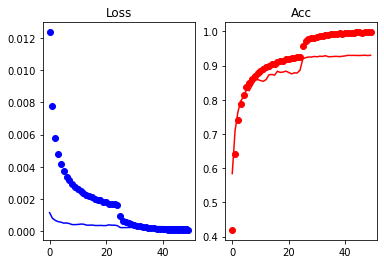

In [17]:
import matplotlib.pyplot as plt
x = list(range(epochs))
plt.figure()
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(x, history['loss'], 'bo')
plt.plot(x, history['val_loss'], 'b')

plt.subplot(1,2,2)
plt.title('Acc')
plt.plot(x, history['acc'], 'ro')
plt.plot(x, history['val_acc'], 'r')



In [15]:
print(history) 